<a href="https://colab.research.google.com/github/shekhart47/NLP-Projects/blob/master/CS329S_Problem_Set_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS329S Problem Set 2

# Overview

In the last assignment, we’ve tested some public ML systems. In this assignment, we’ll familiarize ourselves with how to train and evaluate models. In this assignment, you'll familiarize yourself with the open source HuggingFace API by evaluating fine-tuned models on a variety of criteria. 

# Submission
1. Click ***File > Save a Copy in Drive*** to save your own copy of the document to work in and submit.
2. Please answer all the problems from this problem set in your Colab notebook.
3. Submit **both** `CS329S Problem Set 2.ipynb` notebook file and `CS329S Problem Set 2.pdf` to Gradescope. 
  - To download the `CS329S Problem Set 2.ipynb`: File > Download .ipynb
  - To download the `CS329S Problem Set 2.pdf`: File > Print

Please make sure that your answers are not in collapsed cells for your PDF!

**This assignment is meaty. Start early!**


**Tip**: You can use the colab GPU for this by selecting:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**


# Part I. Understanding pretrained models

Some of the HuggingFace modules that you might find useful for this assignment.
- [`load_dataset`](https://huggingface.co/docs/datasets/loading_datasets.html)
- [`pipelines`](https://huggingface.co/transformers/main_classes/pipelines.html)
- [`Trainer`](https://huggingface.co/transformers/main_classes/trainer.html)

Run the following cells to set up the necessary prerequisites. Feel free to modify the cells to import any module you need.

In [1]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 3.5 MB 2.6 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 895 kB 46.9 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 6.8 MB 16.1 MB/s 
     |████████████████████████████████| 311 kB 3.4 MB/s 
     |████████████████████████████████| 133 kB 39.3 MB/s 
     |████████████████████████████████| 243 kB 44.4 MB/s 
     |████████████████████████████████| 1.1 MB 47.7 MB/s 
     |████████████████████████████████| 271 kB 63.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 44.1 MB/s 


In [2]:
import numpy as np
import random

from datasets import load_dataset
from datasets import load_metric
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt


from pickle import load

## Problem 1: Setup

We’ll examine pretrained language models’ performance for the task of sentiment analysis with two classes. For Problem 1 and Problem 2 of this assignment, you’ll need to pick the following:

- **Fine-tuned model**: choose one pretrained language model that has been fine-tuned on the IMDB dataset from the [HuggingFace Model Hub](https://huggingface.co/models). You can see the list of available models trained on IMDB [here](https://huggingface.co/models?search=imdb). Examples:
    - `roberta-base-imdb` is `robert-base` that has been fine-tuned on the IMDB dataset.
    - `distilbert-base-uncased-imdb` is `distilbert-base-uncased` that has been fine-tuned on the IMDB dataset.

- **Out-of-distribution dataset**: pick a **binary label** sentiment analysis dataset that IS NOT IMDB from HuggingFace Datasets interface (some of them have more than two labels, so make sure you pick one with binary labels!). You can find the list of sentiment analysis tasks [here](https://huggingface.co/datasets?filter=task_ids:sentiment-classification).


### 1.1 Understanding your fine-tuned model [5 points]



#### a. (1 point) What fine-tuned model did you choose? What’s its pretrained LM counterpart?


**Answer**:

I used distilbert-base-uncased as the tuned-model for this task. This model is based on pretrained Google's BERT model

#### b. (1 point) Is your model cased or uncased? Why did you choose that?

**Answer**:

The distilbert-base-uncased model is uncased. This model is trained by distilling based BERT and thus has 60% less parameters than the parent model and is thus faster for inference while maintaining 95% of BERT's performance.

References:

https://huggingface.co/distilbert-base-uncased


https://huggingface.co/docs/transformers/model_doc/distilbert

#### c. (3 points) What is the number of parameters in your model? You can find this number either from the original paper or write code to count its number of parameters.

In [3]:
################## (OPTIONAL) YOUR CODE HERE ##################
# Find the number of parameters in your model
###############################################################

In [4]:
from transformers import pipeline
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertModel, DistilBertConfig


configuration = DistilBertConfig()

# Initializing a model from the configuration
model = DistilBertModel(configuration)

# Accessing the model configuration
configuration = model.config

print(configuration)


DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "transformers_version": "4.16.2",
  "vocab_size": 30522
}



**Answer**:

[YOUR ANSWER HERE]

### 1.2 Understanding the [IMDB dataset](https://ai.stanford.edu/~amaas/data/sentiment/) [3 points]

**Tip**: The IMDB dataset can also be explored in the Hugging Face model hub ([IMDb](https://huggingface.co/datasets/imdb)) 

**Example: Loading Dataset**

The following cell shows how to use the HuggingFace [`Datasets`](https://github.com/huggingface/datasets) library to download and prepare the IMDb dataset. 


In [5]:
dataset = load_dataset("imdb")

dataset
dataset['test'][0]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/84.1M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

{'label': 0,
 'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'

**Alternatively**, you can also read in datasets from raw text. Checkout this [tutorial](https://huggingface.co/transformers/custom_datasets.html?highlight=imdb%20rating%20dataset) for more details.

In [6]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

--2022-02-19 23:15:21--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  25.7MB/s    in 3.9s    

2022-02-19 23:15:25 (20.7 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [7]:
from pathlib import Path

def read_imdb_split(split_dir):
    split_dir = Path(split_dir)
    texts = []
    labels = []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir is "neg" else 1)

    return texts, labels

train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

In [8]:
################## (OPTIONAL) YOUR CODE HERE ##################
# Feel free to write your own code to import the IMDB dataset.
###############################################################

#### a. (1 point) Plot the reviews' lengths (word count) as a histogram for the train set, the test set, and the entire dataset.

- If you need some help generating plots, checkout matplotlib [tutorial](https://matplotlib.org/3.1.1/gallery/statistics/hist.html)


In [9]:
################## YOUR CODE HERE ##################
# Plot the review's lengths
####################################################

In [10]:
def get_reviews_length(data):
  text_length = [len(item) for item in data]
  return text_length

In [11]:
text_length_train = get_reviews_length(train_texts)
text_length_test = get_reviews_length(test_texts)
all_reviews = train_texts + test_texts
all_review_length = get_reviews_length(all_reviews)

(array([1.7426e+04, 5.3820e+03, 1.4910e+03, 5.3500e+02, 1.4800e+02,
        1.1000e+01, 4.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   52. ,  1417.2,  2782.4,  4147.6,  5512.8,  6878. ,  8243.2,
         9608.4, 10973.6, 12338.8, 13704. ]),
 <a list of 10 Patch objects>)

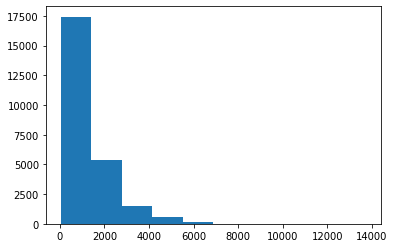

In [12]:
plt.hist(text_length_train)

(array([1.7044e+04, 5.6340e+03, 1.5500e+03, 5.4400e+02, 2.2100e+02,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([   32. ,  1327.6,  2623.2,  3918.8,  5214.4,  6510. ,  7805.6,
         9101.2, 10396.8, 11692.4, 12988. ]),
 <a list of 10 Patch objects>)

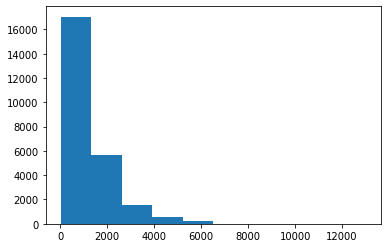

In [13]:
plt.hist(text_length_test)

(array([3.4883e+04, 1.0845e+04, 2.9210e+03, 1.0330e+03, 2.9300e+02,
        1.4000e+01, 4.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   32. ,  1399.2,  2766.4,  4133.6,  5500.8,  6868. ,  8235.2,
         9602.4, 10969.6, 12336.8, 13704. ]),
 <a list of 10 Patch objects>)

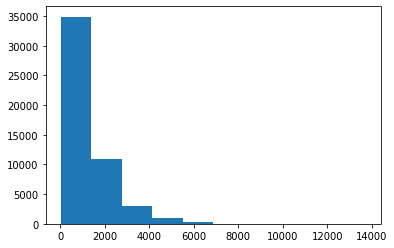

In [14]:
plt.hist(all_review_length)

**Answer**:

[YOUR ANSWER HERE]

#### b. (1 point) Report the label distribution (number of positive and negative examples) for both the train and test splits.

In [15]:
################## YOUR CODE HERE ##################
# Find the label distributions
####################################################

In [16]:
from collections import Counter
counter_train = Counter()
counter_train.update(train_labels)
print("Label Distribution - Train : ", counter_train)
counter_test = Counter()
counter_test.update(test_labels)
print("Label Distribution - Test : ", counter_test)

Label Distribution - Train :  Counter({1: 12500, 0: 12500})
Label Distribution - Test :  Counter({1: 12500, 0: 12500})


**Answer**:

[YOUR ANSWER HERE]

#### c. (1 point) What evaluation metric(s) would be appropriate for this dataset? Why?

**Answer**:

After looking at the label distribution in the dataset, since this is a binary (sequence) classification model, we will use the following classification metrics to evaluate the model's predictions against the ground truth:

1) Precision

2) Recall

3) Fscore

### 1.3 Understanding the out-of-distribution dataset [3 points]

#### a. (1 point) What's the name of your out-of-distribution dataset? Include a link. 

**Answer**:


Amazon Reviews Dataset : https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Mobile_Electronics_v1_00.tsv.gz

NOTE : 
The dataset is also loaded in huggigface list of datasets, so I'll be using huggingface version of this dataset, which in turn will fecth it from the above s3 bucket.  After loading the data, I will be using keras framework to build and test my model

#### b. (1 point) Describe your dataset, including its splits, its columns, and their statistics. 

In [17]:
################## YOUR CODE HERE ##################
# Load your data and find your dataset's statistics
####################################################

**Answer**:

Code for the loading the dataset : 

NOTE : The below commands will load all the dataset from the s3 bucket with the predefined train split. We will use this dataset, to create our own train and test splits

In [18]:
from datasets import list_datasets
from datasets import load_dataset
import pandas as pd

datasets_list = list_datasets()
len(datasets_list)
print(', '.join(dataset for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, americas_nli, ami, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, beans, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, biosses, blbooks, blbooksgenre, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bnl_newspapers, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, casino, catalonia_independence, cats_vs_dogs, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt

In [19]:
dataset = load_dataset('amazon_us_reviews', 'Mobile_Electronics_v1_00')

Downloading:   0%|          | 0.00/2.78k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.96k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

Dataset amazon_us_reviews downloaded and prepared to /root/.cache/huggingface/datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

We make a new columns called Sentiment by transforming the star_rating column, by assigning all rating with score >=3 as 1 and 0 otherwise,, . Next, we extract review_body and Sentiment from the dataset and this gives us our complete dataset for buidling our model.

In [20]:
def process_dataset(dataset):
  dataset = pd.DataFrame(dataset['train'][:])
  dataset["Sentiment"] = dataset["star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
  dataset['Sentiment'] = dataset['Sentiment'].map({'positive':1, 'negative':0})
  dataset = dataset[['review_body','Sentiment']]
  dataset.columns = ['Reviews','Sentiment']

  return dataset

In [21]:
dataset = process_dataset(dataset)

In [22]:
dataset.head()

,Reviews,Sentiment
0,"As advertised. Everything works perfectly, I'm...",1
1,it's great,1
2,These work great and fit my life proof case fo...,1
3,Work very well but couldn't get used to not he...,1
4,"Be careful with these products, I have bought ...",0


Summary Statistics - All data

In [23]:
dataset['Review_Length'] = dataset['Reviews'].apply(lambda x : len(x))

Histogram of Review Length for entire dataset


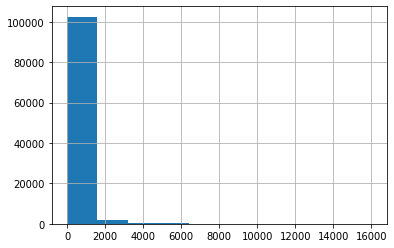

In [24]:
print("Histogram of Review Length for entire dataset")
dataset['Review_Length'].hist()

In [25]:
dataset['Sentiment'].value_counts()

1    80077
0    24898
Name: Sentiment, dtype: int64

Word Count in Raw (unprocessed) Dataset

In [26]:
counter = Counter()
result = [counter.update(item.split()) for item in dataset['Reviews']]
result = pd.DataFrame.from_dict(counter, orient='index').reset_index()
result = result.rename(columns={'index':'Token', 0:'count'})

In [27]:
print("Summary Statistics for features : Review Length and Sentiment")
dataset[['Review_Length','Sentiment']].describe()

Summary Statistics for features : Review Length and Sentiment


,Review_Length,Sentiment
count,104975.000000,104975.000000
mean,342.306425,0.762820
std,526.121531,0.425356
min,0.000000,0.000000
25%,115.000000,1.000000
50%,190.000000,1.000000
75%,381.000000,1.000000
max,16009.000000,1.000000


Top 100 words occuring in the raw(unprocessed) dataset

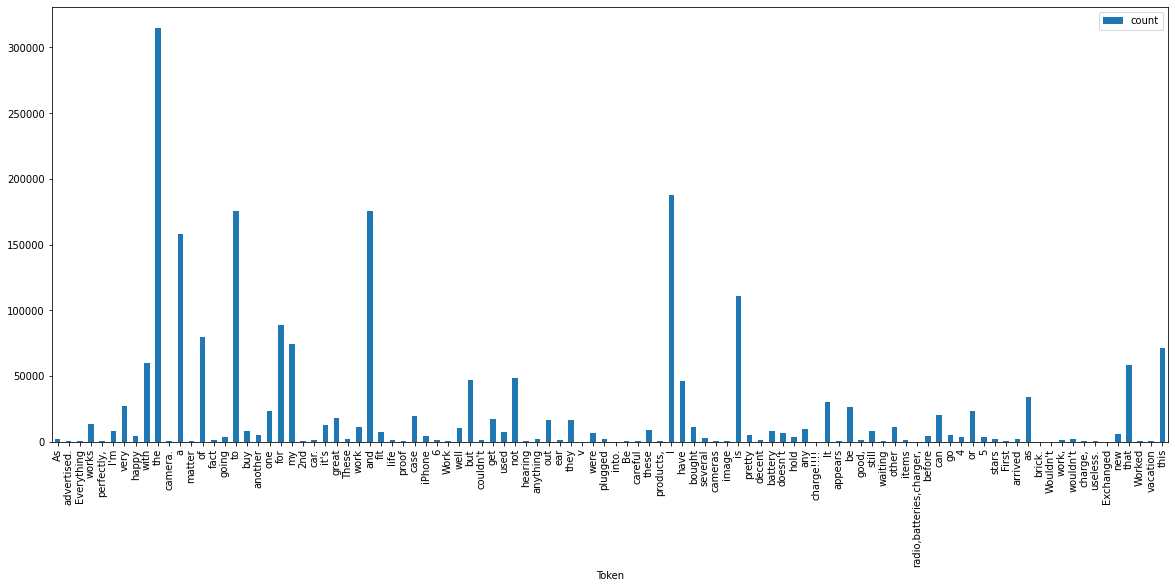

In [28]:
result.head(100).plot.bar(x = 'Token', y = 'count', figsize = (20,8))

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['Reviews'], dataset['Sentiment'], test_size=0.33, random_state=412)
X_train = pd.DataFrame(X_train, columns = ['Reviews'])
X_test = pd.DataFrame(X_test, columns = ['Reviews'])

Word Count in Raw (unprocessed) Train Dataset

In [30]:
counter = Counter()
result = [counter.update(item.split()) for item in X_train['Reviews']]
result_train = pd.DataFrame.from_dict(counter, orient='index').reset_index()
result_train = result_train.rename(columns={'index':'Token', 0:'count'})

#### c. (1 point) Report the label distribution (number of positive and negative examples) for both the train and test splits.

In [31]:
################## YOUR CODE HERE ##################
# Plot the label distribution
####################################################

In [32]:
print("Label Distribution  - Train Dataset")
Counter(y_train)

Label Distribution  - Train Dataset


Counter({0: 16762, 1: 53571})

In [33]:
print("Label Distribution  - Test Dataset")
Counter(y_test)

Label Distribution  - Test Dataset


Counter({0: 8136, 1: 26506})

**Answer**:

[YOUR ANSWER HERE]

## Problem 2. Training from scratch v.s. pretrained-model

### 2.1 Train a sentiment analysis model from scratch [10 points with 5 extra credit]

Use any framework (e.g. sklearn, PyTorch, Keras, TensorFlow) and any architecture (e.g. Logistic Regression, LSTM, Transformers), train a sentiment analysis model from scratch to get an accuracy of at least 85% on the test split of the IMDB dataset.

- **5 extra points if your model’s accuracy is above 90%**

In [34]:
#############
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.linear_model import LogisticRegression
import string
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split 
from pickle import dump
from sklearn.pipeline import Pipeline

####################################################

In [35]:
train = pd.DataFrame(list(zip(train_texts, train_labels)), columns = ['review','sentiment'])
test = pd.DataFrame(list(zip(test_texts, test_labels)), columns = ['review','sentiment'])
data = pd.concat([train, test], axis = 0)

In [36]:
def clean_text1(text):
    text=text.lower()
    text=re.sub('\[.*?\]','',text)
    text=re.sub('[%s]'%re.escape(string.punctuation),'',text)
    text=re.sub('\w*\d\w*','',text)
    return text



def clean_text2(text):
    text=re.sub('[''"",,,]','',text)
    text=re.sub('\n','',text)
    return text


    
cleaned1=lambda x:clean_text1(x)
cleaned2=lambda x:clean_text2(x)

In [37]:
def get_cleaned_train_test_dataset(cleaned1,cleaned2, data):
  data['review']=pd.DataFrame(data.review.apply(cleaned1))
  data['review']=pd.DataFrame(data.review.apply(cleaned2))
  x = data.iloc[0:,0].values
  y = data.iloc[0:,1].values
  xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size = 0.5,random_state = 412)

  return xtrain,xtest,ytrain,ytest

In [38]:
xtrain,xtest,ytrain,ytest = get_cleaned_train_test_dataset(cleaned1,cleaned2, data)




def build_pipeline():
  tf = TfidfVectorizer()

  classifier=LogisticRegression()
  model=Pipeline([('vectorizer',tf),('classifier',classifier)])

  return model

In [39]:
custom_model = build_pipeline()

In [40]:
def train_model(custom_model, xtrain,ytrain):
  custom_model.fit(xtrain,ytrain)
  return custom_model

In [41]:
custom_model = train_model(custom_model, xtrain,ytrain)

In [42]:
def generate_predictions(custom_model, xtest):
  ypred=custom_model.predict(xtest)
  return ypred

In [43]:
ypred = generate_predictions(custom_model, xtest)


In [44]:
import joblib
def evaluate_imdb_test_predictions(ytest,ypred, custom_model):
  a=confusion_matrix(ytest,ypred)
  tp = a[0,0]
  fp = a[0,1]
  fn = a[1,0]
  tn = a[1,1]

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  accuracy = (tp+tn)/(tp+tn+fp+fn)

  F1 = 2 * (precision * recall) / (precision + recall)

  print("Accuracy : Test Set : ", accuracy_score(ypred,ytest) )
  print("F1 Score : Test Set : ", F1)
  print("Precision : Test Set : ", precision)
  print("Recall : Test Set : ", recall)
  if accuracy > 0.85:

    joblib.dump(custom_model, 'custom_model.joblib')
    print("model saved")

In [45]:
evaluate_imdb_test_predictions(ytest,ypred, custom_model)

Accuracy : Test Set :  0.89044
F1 Score : Test Set :  0.889933694996986
Precision : Test Set :  0.8812574612017509
Recall : Test Set :  0.8987824675324675
model saved


In [46]:
def save_dataset(dataset, filename):
  dump(dataset, open(filename, 'wb'))
  print('Saved: %s' % filename)

In [47]:
save_dataset([xtrain, ytrain], 'train.pkl')
save_dataset([xtest, ytest], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


In [48]:
def compute_performance(predictions, y_ground_truth):
    result = []
    for i in range(1,1000,1):
        threshold = i/1000
        y_pred_int  = [1 if item >= threshold else 0 for item in predictions]
        
  

        a = confusion_matrix(y_ground_truth,y_pred_int)

        tp = a[0,0]
        fp = a[0,1]
        fn = a[1,0]
        tn = a[1,1]
        
        precision = tp/(tp+fp)
        recall = tp/(tp+fn)
        accuracy = (tp+tn)/(tp+tn+fp+fn)
        
        F1 = 2 * (precision * recall) / (precision + recall)
        
        
        result.append((threshold, precision, recall,accuracy,F1))
    result_df = pd.DataFrame(result, columns = ['Threshold','Precision','Recall','Accuracy','F1']).sort_values(by = 'F1',ascending = False)
    return result_df

In [49]:
# predictions_train = list(model.predict(xtrain))
# model_result = compute_performance(predictions_train, list(ytrain))

### 2.2 Evaluate your model and the fine-tuned model on IMDB [11 points]

**Tip**: You might find [`TextClassificationPipeline`](https://huggingface.co/transformers/main_classes/pipelines.html#transformers.TextClassificationPipeline) helpful. 

#### a. (1 point) Randomly sample 1000 examples from the test split.

In [50]:
################## YOUR CODE HERE ##################

####################################################

In [73]:


testX = pd.DataFrame(xtest)
testLabels = pd.DataFrame(ytest)
test_Data = pd.concat([testX, testLabels], axis = 1)


print( "1000 samples in terms of  Percetange : ", 1000 / testX.shape[0])
sample_percentage = 1000 / test_Data.shape[0]
sample_testData = test_Data.sample(frac= sample_percentage, replace=True, random_state=412)
sample_testX = sample_testData.iloc[:,:-1]
sample_test_Labels = sample_testData.iloc[:,-1]
sample_testX = sample_testX.values
sample_test_Labels = sample_test_Labels.values

1000 samples in terms of  Percetange :  0.04


#### b. (2 points) Use **your model** to make predictions on these examples and output predicted labels and associated probabilities.

In [74]:
################## YOUR CODE HERE ##################

####################################################

sample_probabilities = custom_model.predict_proba(sample_testX.ravel())

In [75]:
sample_probabilities = list(sample_probabilities[:,1])
predictions_labels_sample = [1 if item >= 0.5 else 0 for item in sample_probabilities] 
sample_predictions = pd.DataFrame(sample_probabilities, columns = ['Probabilities'])
sample_predictions['Labels'] = predictions_labels_sample

In [76]:
sample_predictions

,Probabilities,Labels
0,0.980294,1
1,0.801857,1
2,0.389746,0
3,0.705704,1
4,0.006943,0
...,...,...
995,0.874199,1
996,0.527265,1
997,0.874184,1
998,0.675449,1


#### c. (2 points) Evaluate and report **your model’s** performance on these 1000 examples using the metric specified in 1.2 (c).

In [55]:
################## YOUR CODE HERE ##################

####################################################

In [70]:
def get_model_performance(sample_test_Labels, predictions_sample):
    

  a = confusion_matrix(sample_test_Labels,predictions_sample)

  tp = a[0,0]
  fp = a[0,1]
  fn = a[1,0]
  tn = a[1,1]

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  accuracy = (tp+tn)/(tp+tn+fp+fn)

  F1 = 2 * (precision * recall) / (precision + recall)
  print("Model's performance on " , len(sample_test_Labels) ,  " samples of Test Set :  ")
  print("Accuracy : ", accuracy)
  print("Precision : ", precision)
  print("Recall : ", recall)
  print("F1 : ", F1)

In [77]:
get_model_performance(list(sample_test_Labels), predictions_labels_sample)

Model's performance on  1000  samples of Test Set :  
Accuracy :  0.885
Precision :  0.8858800773694391
Recall :  0.8910505836575876
F1 :  0.8884578079534433


In [78]:

# import math
# a = confusion_matrix(predictions_labels_sample,list(sample_test_Labels))

# tp = a[0,0]
# fp = a[0,1]
# fn = a[1,0]
# tn = a[1,1]

# precision = tp/(tp+fp)
# recall = tp/(tp+fn)
# accuracy = (tp+tn)/(tp+tn+fp+fn)

# F1 = 2 * (precision * recall) / (precision + recall)

# print("Accuracy on Sample Set :", (accuracy * 100))
# print("Precision on Sample Set :", (precision * 100))
# print("Recall on Sample Set :", (recall * 100))
# print("F1 on Sample Set :", (F1 * 100))


**Answer**:

[YOUR ANSWER HERE]

#### d. (2 points) Use the **fine-tuned model** to make predictions on these examples and output predicted labels and associated probabilities.


In [57]:
################## YOUR CODE HERE ##################
# nlp = pipeline(...)
####################################################
import torch



from transformers import pipeline
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertModel, DistilBertConfig

In [ ]:
# loading train and test dataset



# trainLines, trainLabels = load_dataset('train.pkl')
# testLines, testLabels = load_dataset('test.pkl')


# test_texts, test_labels

#train_texts, train_labels = read_imdb_split('aclImdb/train')


trainLines = pd.DataFrame(train_texts)
trainLabels = pd.DataFrame(train_labels)





train = pd.concat([trainLines,trainLabels], axis = 1)
train.columns = ['reviews','labels']

# trainLines, trainLabels = load_dataset('train.pkl')
# testLines, testLabels = load_dataset('test.pkl')

#test_texts, test_labels = read_imdb_split('aclImdb/test')
testLines = pd.DataFrame(test_texts)
testLabels = pd.DataFrame(test_labels)
test = pd.concat([testLines,testLabels], axis = 1)

test.columns = ['reviews','labels']



# creating sample dataset from test dataset
print( "1000 samples in terms of  Percetange : ", 1000 / testLines.shape[0])
sample_percentage = 1000 / test.shape[0]
sample_testData = test.sample(frac= sample_percentage, replace=True, random_state=412)
train, val = train_test_split(train, test_size=0.2, random_state=42, shuffle=True)



# building model and tokenizer object
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(set(train['labels']))).to('cuda')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
tokenizer.max_model_input_sizes

In [116]:
# encoding train, validation , test and sample_test datasets

train_encodings = tokenizer(train['reviews'].to_list(), truncation=True, padding = "max_length")
val_encodings = tokenizer(val['reviews'].to_list(), truncation=True, padding = "max_length")
test_encodings = tokenizer(test['reviews'].to_list(), truncation=True, padding = "max_length")

sample_testData_encodings = tokenizer(sample_testData['reviews'].to_list(), truncation=True, padding = "max_length")

In [117]:
# make torch dataset
class my_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [118]:
# transforming pandas dataset to toch dataset

train_dataset = my_Dataset(train_encodings, train['labels'].to_list())
val_dataset = my_Dataset(val_encodings, val['labels'].to_list())
test_dataset = my_Dataset(test_encodings, test['labels'].to_list())
sample_testDataset = my_Dataset(sample_testData_encodings, sample_testData['labels'].to_list())

In [119]:
# setting up training arguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    eval_steps=10,                      #print every 10 instead of default 500
    logging_steps=10,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [120]:
# setting up trainer object

trainer = Trainer(
    model=model,                         # the instantiated Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

In [121]:
# initiating training of the pipeline
trainer.train()
metrics_train=trainer.state.log_history

Step,Training Loss
10,0.699100
20,0.657800
30,0.488000
40,0.407400
50,0.359600
60,0.413000
70,0.581600
80,0.376200
90,0.423300
100,0.426300


Saving model checkpoint to ./results/checkpoint-5000
Configuration saved in ./results/checkpoint-5000/config.json
Model weights saved in ./results/checkpoint-5000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-5500
Configuration saved in ./results/checkpoint-5500/config.json
Model weights saved in ./results/checkpoint-5500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-6000
Configuration saved in ./results/checkpoint-6000/config.json
Model weights saved in ./results/checkpoint-6000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-6500
Configuration saved in ./results/checkpoint-6500/config.json
Model weights saved in ./results/checkpoint-6500/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-7000
Configuration saved in ./results/checkpoint-7000/config.json
Model weights saved in ./results/checkpoint-7000/pytorch_model.bin
Saving model checkpoint to ./results/checkpoint-7500
Configuration saved in ./results/checkpoin

In [122]:
#print evaluation metrics on validation dataset
metrics=trainer.evaluate()
#print(metrics)

out_path = './results'
trainer.save_model(out_path)
tokenizer.save_pretrained(out_path)

# Accuracy metrics on entire test dataset
predictions=trainer.predict(test_dataset)


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 4


Saving model checkpoint to ./results
Configuration saved in ./results/config.json
Model weights saved in ./results/pytorch_model.bin
tokenizer config file saved in ./results/tokenizer_config.json
Special tokens file saved in ./results/special_tokens_map.json
***** Running Prediction *****
  Num examples = 25000
  Batch size = 4


**Predictions on Sample Test Dataset**

In [129]:
predictions_sample=trainer.predict(sample_testDataset)
y_pred = list(predictions_sample.label_ids)
ground_truth = sample_testData['labels'].values.tolist()

***** Running Prediction *****
  Num examples = 1000
  Batch size = 4


In [130]:
sample_testData

,reviews,labels
24562,I would think that this was one of those films...,0
12172,"For sheer quality of performance and the ""thea...",1
9061,Why is it better? Because it's true to the dar...,1
20130,The beginning of the movie was confusing and t...,0
13530,Here is a rundown of a typical Rachael Ray Sho...,0
...,...,...
13982,<br /><br />After the wit and liveliness of Hi...,0
8866,The retelling of a classic story is set to the...,1
9054,If you find the first 30 minutes of this film ...,1
15469,There is only one reason this movie is watchab...,0


In [131]:
predictions_tensor = torch.from_numpy(predictions_sample.predictions)

In [132]:
#predictions_tensor = torch.from_numpy(predictions_sample.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)
class1_probabilities = list(predictions[:,1])
class1_labels = [1 if item >= 0.5 else 0 for item in class1_probabilities]
result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])

In [133]:

result_sample_test

,Probabilities,Labels
0,0.001656,0
1,0.999644,1
2,0.999602,1
3,0.000420,0
4,0.000587,0
...,...,...
995,0.000319,0
996,0.999393,1
997,0.999252,1
998,0.001226,0


#### e. (2 points) Evaluate and report the **fine-tuned model’s** performance on these 1000 examples using the metric specified in 1.2 (c).

In [ ]:
################## YOUR CODE HERE ##################
# Run inference on the sampled examples
# - https://huggingface.co/transformers/main_classes/pipelines.html

# Compute the metrics on your examples
# - https://huggingface.co/docs/datasets/using_metrics.html

####################################################

**Answer**:

[YOUR ANSWER HERE]

In [134]:
ground_truth = list(sample_testData['labels'])
get_model_performance(ground_truth, list(result_sample_test['Labels']))

Model's performance on  1000  samples of Test Set :  
Accuracy :  0.927
Precision :  0.9366053169734151
Recall :  0.916
F1 :  0.9261880687563195


#### f. (2 points) Compare the performance of the model trained from scratch and the fine-tuned model.

**Answer**:

The custom-model's performance as compared to the tuned-model on 1000 sameples of imdb-test set is as follows:

Custom-Model Performance Metrics :

*   Accuracy :  0.885
*   Precision :  0.8858800773694391
*   Recall :  0.8910505836575876
*   F1 :  0.8884578079534433



Tuned Model Performance Metrics :


*   Accuracy :  0.927
*   Precision :  0.9366053169734151
*   Recall :  0.916
*   F1 :  0.9261880687563195








Observation :

As can be observed from the performance metrics, the fine-tuned model outperforms the custom model on all metrics (as specified in 1.2 C)

### 2.3 Error analysis of the fine-tuned model [10 points]

Next, do error analysis on the examples that the fine-tuned model failed to predict correctly. This is a common debugging step where buckets of errors are identified to inform how the model might be improved.

#### a. (1 points) Pull out the examples that your fine-tuned model made errors on. Examine multiple examples to see if you can spot a pattern.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In the below cell, I pulled all the examples on which the fine-tuned model has made an error

In [135]:
sample_testData_copy = sample_testData.copy(deep = False)
sample_testData_copy = sample_testData_copy.reset_index()
sample_testData_copy = sample_testData_copy.iloc[:,1:]
data_predictions_ground_truth= pd.concat([result_sample_test, sample_testData_copy], axis =  1)
data_predictions_ground_truth.columns = ['Probabilities','Predicted_Label','Review','Ground_Truth']

mismatches = data_predictions_ground_truth[data_predictions_ground_truth['Predicted_Label']!= data_predictions_ground_truth['Ground_Truth']]

In [136]:
matches = data_predictions_ground_truth[data_predictions_ground_truth['Predicted_Label'] == data_predictions_ground_truth['Ground_Truth']]

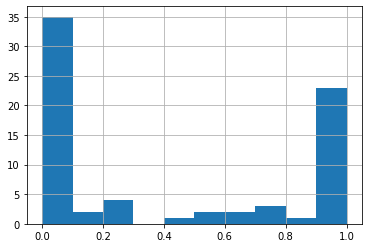

In [138]:
mismatches['Probabilities'].hist()

Observation:

The probability distribution for such eamples is at the extremes for most of the examples


#### b. (3 points) Identify at least 1 pattern that you believe your model is missing. Include at least 3 examples from the data that support your hypothesis.


**Answer**:

In my opinion the model is unable to correctly classify sentenes where the reviewer expresses his own opinion on the subject discussed in the film rather than the film itself. To add to it, if the reviewer speaks both in favor and against the the movie in question, the model falsely classifies that review in the wrong category without taking into account the context in which the user expresses their opinion.

The below examples demonstrate this finding :

#### c. (2 points) Explain why these examples might have been difficult for the fine-tuned model to correctly make predictions on.

In [143]:
mismatches['Review'].values.tolist()[0]

'This film marked the end of the "serious" Universal Monsters era (Abbott and Costello meet up with the monsters later in "Abbott and Costello Meet Frankentstein"). It was a somewhat desparate, yet fun attempt to revive the classic monsters of the Wolf Man, Frankenstein\'s monster, and Dracula one "last" time.<br /><br />I say desparate, because in the previous film, "House of Frankenstein," both Dracula and the Wolf Man are killed according to how the vampire and werewolf legends say they should be (Dracula by the sunlight, and the wolf man by a silver bullet). Yet somehow they return in House of Dracula with no explanation. This movie could have played as a kind of prequel to House of Frankenstein if the Frankenstein monster plot wouldn\'t be continuing chronologically into House of Dracula from House of Frankenstein, and if the wolf man didn\'t get cured. Then there\'d be no plot holes. But since this is not the case, the plots of Dracula and the Wolf Man make no sense.<br /><br />H

In [145]:
mismatches['Review'].values.tolist()[1]

'No, "Lifeforce" is not a great movie.<br /><br />It\'s not a good movie.<br /><br />It is, however, an average movie with some good effects and a compelling storyline (and, of course, Mathilda May). It may actually be one of my favorite SF/horror flicks for the very simple reason that they try to reason their way through the science of the space vampires. How often do you see that? Not even in "Alien" (the SF/horror flick of all time) does science come into the story at all. In "Lifeforce" they are trying to make reason of an unreasonable world.<br /><br />Now, do I think it\'s successful? No. I think the movie has the issue of a massive ensemble cast that Hooper is straining to keep collected and on track and that the viewers have to focus on more than one \'villian\' and there are one too many road trips.<br /><br />To be honest, the movie is eye candy and fun to watch. but there is great potential here for a superior remake to take a hold of what Hooper was trying to do and really 

In [147]:
mismatches['Review'].values.tolist()[3]

'All right, I\'ll grant you that some of the science in "Doppelganger" (or "Journey To The Far Side Of The Sun") is kind of dopey.The idea of an entire planet existing undetected (because we can\'t see it on the other side of our sun) doesn\'t hold up at all - any Astronomy 101 student knows that another planet the size of Earth would cause gravitational perturbances in the motions of other planets. That\'s how astronomers deduced the existence of Pluto, after all, and that\'s how they find comets and asteroids and moons on a regular basis.<br /><br />And the idea that a mirror image Earth somehow evolved in almost perfect parallel to our Earth, down to English speaking scientists and human counterparts for each human born on our Earth...that takes things out of \'hard science\' fiction and into "Twilight Zone" territory. That\'s not necessarily a bad thing, but it requires a major suspension of critical thinking to accept and enjoy. <br /><br />But man, this movie knocked my socks off

**Answer**:

>>>EXPRESS YOUR OWN OPINION ON THESE EXAMPLES<<<

#### d. (2 points) Manually create 3 examples that conform to the pattern you observed, and run inference on them using the model. What did you find?

In [ ]:
################## YOUR CODE HERE ##################
# Inference on your own examples
####################################################

In [173]:
custom_review1 = "The spider man movie is a work of fiction which is both good and bad. Overall the acting by tom holland is okay however nothing compared to what the actors of 60s. Those guys were the masters of their skill and showed real class. It's hard to find such talent today but I guess spider man is watchable " 
label_1 = 1

custom_review2 = "There is a special place reserved for people who think they make the world work. The policies established by these great coutries are funny. Even my dog, alfie makes good policies than the greatest leaders I know. But I believe these are my opinion only :)"
labels_2 = 0

custom_review3 = "Alright, so I'll admit this movies got a lot of bad reviews and it more or less flopped at the box offices when it first came out but that doesn't mean it's total garbage. In fact I'd go one further and say that Pluto Nash is the perfect movie to watch after eating on some golden teachers, you'll begin to explore at length the intricacies of the plot as the special effects take you to the next level and beyond. I'm proud to say that I not only own a copy of this movie but that I was probably one of the few people to repeated purchase this movie when it was available on Direct TV, way, way back in the day. For this reason Pluto Nash packs a good amount of nostalgia which is something I throughly enjoy and actively look for. Eddie Murphys films have usually stood the test of time and with his recent reemergence back into the Hollywood spotlight you can be sure that there will be people going back to watch his Coming to America Life  or even Vampire in Brooklyn movies with enjoyment, so why not make Pluto Nash one of those must see films on your list."
labels_3 = 0

reviews = [custom_review1, custom_review2, custom_review3]
labels = [label_1, labels_2, labels_3]

custom_examples = pd.DataFrame(list(zip(reviews, labels)), columns = ['reviews','ground_truth'])

In [174]:
def make_predictions_custom_data(data):
  sample_testData_encodings = tokenizer(data['reviews'].to_list(), truncation=True, padding = "max_length")
  sample_testDataset = my_Dataset(sample_testData_encodings, data['ground_truth'].to_list())
  predictions_sample=trainer.predict(sample_testDataset)
  y_pred = list(predictions_sample.label_ids)
  predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  #predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  resulting_probabilities = pd.DataFrame(predictions)
  class1_probabilities = list(predictions[:,1])
  class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
  result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])
  return result_sample_test

In [175]:
result_custom_examples = make_predictions_custom_data(custom_examples)

***** Running Prediction *****
  Num examples = 3
  Batch size = 4


In [176]:
result_custom_sample = pd.concat([result_custom_examples, custom_examples], axis = 1)
result_custom_sample

,Probabilities,Labels,reviews,ground_truth
0,0.002789,0,The spider man movie is a work of fiction whic...,1
1,0.999353,1,There is a special place reserved for people w...,0
2,0.998855,1,"Alright, so I'll admit this movies got a lot o...",0


**Answer**:

In these examples I found that expressing opinions by comparing the work done by one actor with actors of another era and making a positive comment about the movie as a whole, along with making comments with a tone of sarcasm and the sense of using words like 'funny' and avoiding negative connotations words by using 'opposite of logical' (which would ideally translate to illogical) are not understood by the model , i.e. the context of the words, and thus the sentences are missclassified.

#### e. (2 points) Suggest what steps we might take to address this error bucket.


**Answer**:

In my opinion, to truly classify the labels correctly, the model needs to also understand the context in which words are being written. While Sarcasm can be subtle, yet the relative placement of words can also be used by the model as a feature to understand the true intent behind a review/comment. An ideal way to approach this would be to gather a stack of target words that display sentiment shifts (sarcastic words) based on context; And with an objective word given an expression, to then identify whether the objective word is used in an exact or sarcastic sense. This information can be collected by the use of an information retrieval system.


References :

https://www.sciencedirect.com/science/article/pii/S2214785320368164

### 2.4 Pertubation Analysis [10 points]

Inputs, especially inputs by users, might contain a lot of noise (e.g. misspelling, repeated chaaaaaaaaracter, missing punctuation, etc.). You want to see how well your models perform on input with noises.

#### a. (2 points) Write a function to randomly add noise to an input while preserving its label. Here are some ideas to consider (you can combine them too, e.g. 10% of the time do this, 20% of the time do this):

- Randomly remove a character
- Randomly repeat a character or a phrase
- Replace a word with a similar word 


In [ ]:
################## YOUR CODE HERE ##################
# def add_random_noice(sentence):
# 
####################################################

In [177]:
import string
import re
from os import listdir
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pickle import dump

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [213]:

def add_random_noice(sentence):

  # repeat characters
  for i in range(10):
    sentence = sentence.split()
    string_variable = random.choice(sentence)
    new_string = string_variable + string_variable[-1] * len(string_variable)
    sentence = ' '.join(sentence)
    sentence = sentence.replace(string_variable, new_string)

  # remoeve punctuations from the sentence
  sentence = sentence.split()
  re_punc = re.compile('[%s]' % re.escape(string.punctuation))
  # remove punctuation from each word
  tokens = [re_punc.sub('', w) for w in sentence]
  # remove remaining tokens that are not alphabetic
  sentence = ' '.join(tokens)



  return sentence

#### b. (1 point) Apply this function to 500 samples in your test split.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

# load the test.pkl file 


In [228]:
sample_percentage = 500 / test.shape[0]
sample_testData = test.sample(frac= sample_percentage, replace=True, random_state=412)
sample_testData['reviews'] = sample_testData['reviews'].apply(lambda x : add_random_noice(x)) 

In [229]:
sample_testData

,reviews,labels
24562,I would think that this was one of those films...,0
12172,For sheer qualityyyyyyyy offf performance and ...,1
9061,Why isssssss it better Because its true to the...,1
20130,The beginning of theeee movie wasss confusing ...,0
13530,Here is a rundownnnn offf a typical Rachael Ra...,0
...,...,...
2568,A greaat movie aabout triumph over aall the na...,1
21980,I felt as though the two hours I spent watchin...,0
19545,Unlike one of theeee reviewers below I dont th...,0
12431,Greaaaaaaaat music greaaaaaaaattttttt daaaaaaa...,1


#### c. (2 points) Use your model to make predictions on these noisy examples and output predicted labels and associated probabilities.

In [230]:
predictions_noisy_sample_probabilities = custom_model.predict_proba(sample_testData['reviews'].values)

In [231]:
sample_probabilities = list(predictions_noisy_sample_probabilities[:,1])
predictions_labels_sample = [1 if item >= 0.5 else 0 for item in sample_probabilities] 
sample_predictions = pd.DataFrame(sample_probabilities, columns = ['Probabilities'])
sample_predictions['Labels'] = predictions_labels_sample

In [232]:
sample_predictions

,Probabilities,Labels
0,0.279210,0
1,0.472669,0
2,0.883975,1
3,0.230014,0
4,0.143551,0
...,...,...
495,0.703604,1
496,0.107981,0
497,0.241325,0
498,0.911046,1


In [206]:
################## YOUR CODE HERE ##################

####################################################

#### d. (1 point) Evaluate your model’s performance on these noisy examples using the metric specified in 1.2 (c).

In [207]:
################## YOUR CODE HERE ##################

####################################################

In [233]:
get_model_performance(list(sample_testData['labels']), list(sample_predictions['Labels']))

Model's performance on  500  samples of Test Set :  
Accuracy :  0.896
Precision :  0.9173228346456693
Recall :  0.8825757575757576
F1 :  0.8996138996138996


#### e. (2 points) Use the fine-tuned model to make predictions on these noisy examples and output predicted labels and associated probabilities.

In [209]:
################## YOUR CODE HERE ##################

####################################################

In [234]:
sample_testData_encodings = tokenizer(sample_testData['reviews'].to_list(), truncation=True, padding = "max_length")
sample_testDataset = my_Dataset(sample_testData_encodings, sample_testData['labels'].to_list())
predictions_sample=trainer.predict(sample_testDataset)
y_pred = list(predictions_sample.label_ids)
ground_truth = sample_testData['labels'].values.tolist()
predictions_tensor = torch.from_numpy(predictions_sample.predictions)
#predictions_tensor = torch.from_numpy(predictions_sample.predictions)
predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
predictions = predictions.cpu().detach().numpy()
resulting_probabilities = pd.DataFrame(predictions)
class1_probabilities = list(predictions[:,1])
class1_labels = [1 if item >= 0.5 else 0 for item in class1_probabilities]
result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])

***** Running Prediction *****
  Num examples = 500
  Batch size = 4


In [235]:
result_sample_test

,Probabilities,Labels
0,0.008882,0
1,0.996972,1
2,0.999276,1
3,0.000431,0
4,0.000444,0
...,...,...
495,0.998118,1
496,0.000365,0
497,0.000795,0
498,0.976107,1


#### f. (1 point) Evaluate the fine-tuned model’s performance on these noisy examples using the metric specified in 1.2 (c).

In [226]:
################## YOUR CODE HERE ##################

####################################################

In [236]:
get_model_performance(list(sample_testData['labels']), list(result_sample_test['Labels']))

Model's performance on  500  samples of Test Set :  
Accuracy :  0.866
Precision :  0.937007874015748
Recall :  0.8235294117647058
F1 :  0.8766114180478821


#### g. (1 point) Compare the performance of your model and the fine-tuned model on these noisy samples.


**Answer:**


The performance of the custom model in comparison to the fine-tuned model is as follows:

Custom-Model:


*   Accuracy :  0.896
*   Precision :  0.9173228346456693
*   Recall :  0.8825757575757576
*   F1 :  0.8996138996138996




Fine-Tuned Model:

*   Accuracy :  0.866
*   Precision :  0.937007874015748
*   Recall :  0.8235294117647058
*   F1 :  0.8766114180478821



### 2.5 Slice-based analysis [10 points]

We’ve been evaluating both models on a coarse-grained metric. Let’s take a deeper look into how we can evaluate them on different slices.

Play around with the test split of IMDB -- slice it into different subgroups. Some ideas for slicing your test split:

- By **input lengths** (e.g. maybe your model will perform well on inputs of less than 10 characters but horribly for inputs of more than 1000 characters).
- By **movie names** (can you figure out how to extract movie names from reviews?).
- By **the number of punctuations** in each review.
- etc. Play around with your data!

Choose two slices of data on which your model’s performances are non-trivially different. Each slice should have at least 100 samples.





In [ ]:
# Cell for you to play around with your data. (not graded)

#### a. (5 points) Describe your reason for choosing these two slices. Explain why the model might perform differently on them.

Punctuation

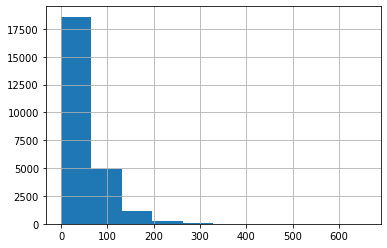

In [239]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
test['punctuations'] = test['reviews'].apply(lambda x : count(x,set(string.punctuation))   )
test['punctuations'].hist()

In [240]:
split1_length_0_50 = test[test['punctuations'] <= 50]
split2_length_50_max = test[test['punctuations'] > 50]

**Length Of Review**

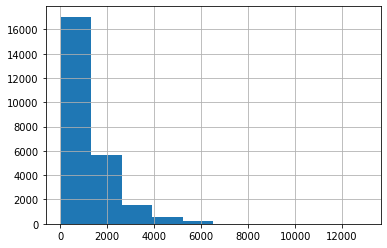

In [241]:
test['input_length'] = test['reviews'].apply(lambda x : len(x))
test['input_length'].hist()

In [242]:
split1_length_0_2000 = test[test['input_length'] <= 2000]
split2_length_2000_max = test[test['input_length'] > 2000]

**Number Of Entities**

In [243]:
import spacy
!python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

     |████████████████████████████████| 12.0 MB 4.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [244]:
def get_entities(text):
  doc = nlp(text)
  count = 0
  for ent in doc.ents:
      count = count + 1
  return count

In [245]:
test['entities'] = test['reviews'].apply(lambda x : get_entities(x))

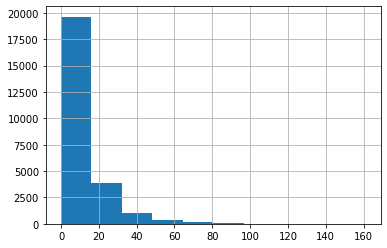

In [246]:
test['entities'].hist()

In [247]:
split1_length_0_15 = test[test['entities'] <= 15]
split2_length_15_max = test[test['entities'] > 15]

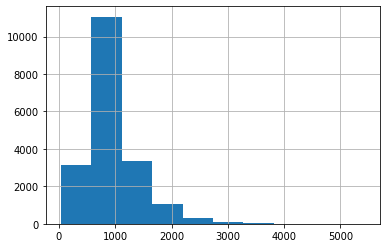

In [248]:
split1_length_0_15['input_length'].hist()

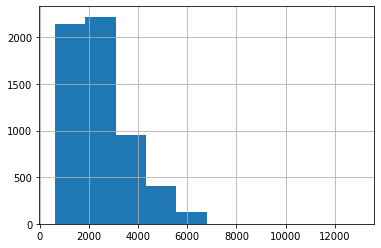

In [249]:
split2_length_15_max['input_length'].hist()

#### b. (2 points) Write code to extract these two slices from your test split.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Slice 1 : Length of Review**

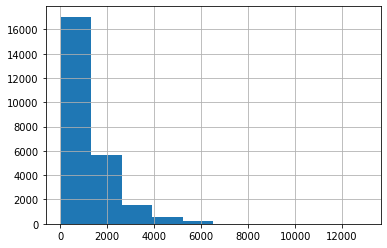

In [250]:
test['input_length'] = test['reviews'].apply(lambda x : len(x))
test['input_length'].hist()

In [251]:
split1_length_0_2000 = test[test['input_length'] <= 2000]
split2_length_2000_max = test[test['input_length'] > 2000]

#### c. (1 point) Write code to report each slice’s statistics. Report the statistics. 
1. Slice size
2. Label distribution

In [ ]:
################## YOUR CODE HERE ##################

####################################################

**Slice 1 - Length of Review**

**Size of Slices**

In [252]:
print("The size of the slices are as follows : \n")
print( "Total rows in split1_length_0_2000 ",split1_length_0_2000.shape[0])
print( "Total rows in split2_length_2000_max ",split2_length_2000_max.shape[0])

print("The percentage of split1_length_0_2000 as a percentage of all test data : ", (split1_length_0_2000.shape[0]/test.shape[0])*100)
print("The percentage of split2_length_2000_max as a percentage of all test data : ", (split2_length_2000_max.shape[0]/test.shape[0])*100)

The size of the slices are as follows : 

Total rows in split1_length_0_2000  20909
Total rows in split2_length_2000_max  4091
The percentage of split1_length_0_2000 as a percentage of all test data :  83.636
The percentage of split2_length_2000_max as a percentage of all test data :  16.364


**Label Distribution**

In [253]:
print("Label Distribution : \n")

print("Label Distribution of split1_length_0_2000:\n", split1_length_0_2000['labels'].value_counts())
print("Label Distribution of split2_length_2000_max:\n", split2_length_2000_max['labels'].value_counts())

Label Distribution : 

Label Distribution of split1_length_0_2000:
 0    10507
1    10402
Name: labels, dtype: int64
Label Distribution of split2_length_2000_max:
 1    2098
0    1993
Name: labels, dtype: int64


**Slice 2 - Number of Entities**

**Size of Slices**

In [254]:

print("The size of the slices are as follows : \n")
print( "Total rows in split1_length_0_15 ",split1_length_0_15.shape[0])
print( "Total rows in split2_length_15_max ",split2_length_15_max.shape[0])

print("The percentage of split1_length_0_15 as a percentage of all test data : ", (split1_length_0_15.shape[0]/test.shape[0])*100)
print("The percentage of split2_length_15_max as a percentage of all test data : ", (split2_length_15_max.shape[0]/test.shape[0])*100)

The size of the slices are as follows : 

Total rows in split1_length_0_15  19153
Total rows in split2_length_15_max  5847
The percentage of split1_length_0_15 as a percentage of all test data :  76.61200000000001
The percentage of split2_length_15_max as a percentage of all test data :  23.388


**Label Distribution**

In [255]:
print("Label Distribution : \n")

print("Label Distribution of split1_length_0_15:\n", split1_length_0_15['labels'].value_counts())
print("Label Distribution of split2_length_15_max:\n", split2_length_15_max['labels'].value_counts())

Label Distribution : 

Label Distribution of split1_length_0_15:
 0    9992
1    9161
Name: labels, dtype: int64
Label Distribution of split2_length_15_max:
 1    3339
0    2508
Name: labels, dtype: int64


**Answer:**

[YOUR ANSWER HERE]

#### d. (1 point) Write code to evaluate **your model** performance on these two slices, including the metric specified in 1.2 (c) and the confusion matrix.
- [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) may be useful here


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [261]:
def get_performance(custom_model, data):
  
  predictions_sample = custom_model.predict(data.reviews.values)
  predictions_sample = list(predictions_sample)
  predictions_sample = pd.DataFrame(predictions_sample, columns = ['Probabilities'])
  selected_threshold = 0.5
  predictions_sample['Labels'] = predictions_sample['Probabilities'].apply(lambda x :  1 if x >= selected_threshold else  0)
  get_model_performance(list(data['labels']), list(predictions_sample['Labels']))

**Performance Evaluation : Length Of Review**

In [262]:
print("predictions for reviews with length less than 2000")
get_performance(custom_model, split1_length_0_2000)

predictions for reviews with length less than 2000
Model's performance on  20909  samples of Test Set :  
Accuracy :  0.9118561385049501
Precision :  0.8965451603692777
Recall :  0.9257075471698113
F1 :  0.9108930039162598


In [264]:
print("predictions for reviews with length more than 2000")
get_performance(custom_model, split2_length_2000_max)

predictions for reviews with length more than 2000
Model's performance on  4091  samples of Test Set :  
Accuracy :  0.9100464434123686
Precision :  0.877571500250878
Recall :  0.9337960491190603
F1 :  0.9048111743404036


In [265]:
print( "Percentage Difference in Accuracy : ", (0.9118561385049501 - 0.9100464434123686) * 100)

Percentage Difference in Accuracy :  0.18096950925814426


**Performance Evaluation : Number of Entities**

In [266]:
get_performance(custom_model, split1_length_0_15)

Model's performance on  19153  samples of Test Set :  
Accuracy :  0.9146347830627056
Precision :  0.9069255404323459
Recall :  0.9278181632026211
F1 :  0.9172528974138368


In [267]:
get_performance(custom_model, split2_length_15_max)

Model's performance on  5847  samples of Test Set :  
Accuracy :  0.9014879425346332
Precision :  0.8401116427432217
Recall :  0.9233128834355828
F1 :  0.8797494780793319


In [268]:
print( "Percentage Difference in Accuracy : ", (0.9146347830627056 -  0.9014879425346332)*100)

Percentage Difference in Accuracy :  1.3146840528072468


In [269]:
# split1_length_0_50 = test[test['punctuations'] <= 50]
# split2_length_50_max = test[test['punctuations'] > 50]

get_performance(custom_model, split1_length_0_50)

Model's performance on  15676  samples of Test Set :  
Accuracy :  0.9124776728757336
Precision :  0.8946135831381733
Recall :  0.9244420543156763
F1 :  0.9092832583972494


In [270]:
get_performance(custom_model, split2_length_50_max)

Model's performance on  9324  samples of Test Set :  
Accuracy :  0.91001716001716
Precision :  0.8917739925218113
Recall :  0.9310344827586207
F1 :  0.9109814323607426


#### e. (1 point) Write code to evaluate the **fine-tuned model** performance on these two slices, including the metric specified in 1.2 (c) and the confusion matrix.

In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [271]:
def get_performance_on_slice(data):
  sample_testData_encodings = tokenizer(data['reviews'].to_list(), truncation=True, padding = "max_length")
  sample_testDataset = my_Dataset(sample_testData_encodings, data['labels'].to_list())
  predictions_sample=trainer.predict(sample_testDataset)
  y_pred = list(predictions_sample.label_ids)
  predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  #predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  resulting_probabilities = pd.DataFrame(predictions)
  class1_probabilities = list(predictions[:,1])
  class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
  result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])
  get_model_performance(data['labels'], list(result_sample_test['Labels']))
  return 

In [272]:
get_performance_on_slice(split1_length_0_2000)

***** Running Prediction *****
  Num examples = 20909
  Batch size = 4


Model's performance on  20909  samples of Test Set :  
Accuracy :  0.9328040556698073
Precision :  0.9313790806129247
Recall :  0.9346704871060172
F1 :  0.9330218811078801


In [273]:
get_performance_on_slice(split2_length_2000_max)

***** Running Prediction *****
  Num examples = 4091
  Batch size = 4


Model's performance on  4091  samples of Test Set :  
Accuracy :  0.9022243950134441
Precision :  0.8956347215253387
Recall :  0.9028831562974203
F1 :  0.8992443324937028


In [274]:
get_performance_on_slice(split1_length_0_15)

***** Running Prediction *****
  Num examples = 19153
  Batch size = 4


Model's performance on  19153  samples of Test Set :  
Accuracy :  0.934161750117475
Precision :  0.9354483586869495
Recall :  0.9381712335641875
F1 :  0.9368078175895765


In [275]:
get_performance_on_slice(split2_length_15_max)

***** Running Prediction *****
  Num examples = 5847
  Batch size = 4


Model's performance on  5847  samples of Test Set :  
Accuracy :  0.9069608346160424
Precision :  0.886762360446571
Recall :  0.895330112721417
F1 :  0.8910256410256411


## Problem 3. In-Distribution v.s. Out-of-Distribution

In problem 2, when we evaluate the fine-tuned model on the test split that comes from the same distribution the model was fine-tuned on. In this problem, we’ll evaluate the fine-tuned model’s performance on an out-of-distribution test set.


### 3.1 Evaluate the fine-tuned model on an out-of-distribution task [4 points]


#### a. (1 point) If the dataset has a test split, randomly sample 500 examples from the test split. If it doesn’t have a test split, randomly sample 500 samples from the entire dataset.


In [276]:
################## YOUR CODE HERE ##################

####################################################


from datasets import list_datasets
from datasets import load_dataset
import pandas as pd
datasets_list = list_datasets()
len(datasets_list)
print(', '.join(dataset for dataset in datasets_list))

acronym_identification, ade_corpus_v2, adversarial_qa, aeslc, afrikaans_ner_corpus, ag_news, ai2_arc, air_dialogue, ajgt_twitter_ar, allegro_reviews, allocine, alt, amazon_polarity, amazon_reviews_multi, amazon_us_reviews, ambig_qa, americas_nli, ami, amttl, anli, app_reviews, aqua_rat, aquamuse, ar_cov19, ar_res_reviews, ar_sarcasm, arabic_billion_words, arabic_pos_dialect, arabic_speech_corpus, arcd, arsentd_lev, art, arxiv_dataset, ascent_kb, aslg_pc12, asnq, asset, assin, assin2, atomic, autshumato, babi_qa, banking77, bbaw_egyptian, bbc_hindi_nli, bc2gm_corpus, beans, best2009, bianet, bible_para, big_patent, billsum, bing_coronavirus_query_set, biomrc, biosses, blbooks, blbooksgenre, blended_skill_talk, blimp, blog_authorship_corpus, bn_hate_speech, bnl_newspapers, bookcorpus, bookcorpusopen, boolq, bprec, break_data, brwac, bsd_ja_en, bswac, c3, c4, cail2018, caner, capes, casino, catalonia_independence, cats_vs_dogs, cawac, cbt, cc100, cc_news, ccaligned_multilingual, cdsc, cdt

In [277]:
dataset = load_dataset('amazon_us_reviews', 'Mobile_Electronics_v1_00')
dataset = pd.DataFrame(dataset['train'][:])
dataset["Sentiment"] = dataset["star_rating"].apply(lambda score: "positive" if score >= 3 else "negative")
dataset['Sentiment'] = dataset['Sentiment'].map({'positive':1, 'negative':0})
dataset = dataset[['review_body','Sentiment']]
dataset.columns = ['reviews','labels']

Reusing dataset amazon_us_reviews (/root/.cache/huggingface/datasets/amazon_us_reviews/Mobile_Electronics_v1_00/0.1.0/17b2481be59723469538adeb8fd0a68b0ba363bbbdd71090e72c325ee6c7e563)


  0%|          | 0/1 [00:00<?, ?it/s]

In [278]:
sample_percentage = 500/dataset.shape[0]

out_sample_500 = dataset.sample(frac= sample_percentage, replace=True, random_state=412)

In [279]:
out_sample_500

,reviews,labels
90098,This mount survived a motorcycle crash that th...,1
12172,Got these to use on desktop and laptop compute...,1
74597,I love this little guy. I actually own two of ...,1
29930,I bought this amp in need of something for my ...,1
90385,"I love this ebook reader, I can change the fon...",1
...,...,...
65945,Best $20.00 I've ever spent. Nice sound with ...,1
18593,The device works. The software fails to contro...,0
10565,Yeah bad idea to run these @ 1ohm on 3000 watt...,1
104162,"This charger is great, it plugs directly into ...",1


#### b. (1 point) Use the fine-tuned model to make predictions on these examples and output predicted labels and associated probabilities.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [280]:
def make_predictions_out_sample(data):
  sample_testData_encodings = tokenizer(data['reviews'].to_list(), truncation=True, padding = "max_length")
  sample_testDataset = my_Dataset(sample_testData_encodings, data['labels'].to_list())
  predictions_sample=trainer.predict(sample_testDataset)
  y_pred = list(predictions_sample.label_ids)
  predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  #predictions_tensor = torch.from_numpy(predictions_sample.predictions)
  predictions = torch.nn.functional.softmax(predictions_tensor, dim=-1)
  predictions = predictions.cpu().detach().numpy()
  resulting_probabilities = pd.DataFrame(predictions)
  class1_probabilities = list(predictions[:,1])
  class1_labels = [1 if item > 0.5 else 0 for item in class1_probabilities]
  result_sample_test = pd.DataFrame(list(zip(class1_probabilities,class1_labels)), columns = ['Probabilities','Labels'])
  return result_sample_test

In [437]:
out_sample_500 = out_sample_500.reset_index().iloc[:,1:]

result_out_sample_test = make_predictions_out_sample(out_sample_500)

***** Running Prediction *****
  Num examples = 500
  Batch size = 4


In [282]:
out_sample_500
result_out_sample_test

,Probabilities,Labels
0,0.973033,1
1,0.996824,1
2,0.999636,1
3,0.002618,0
4,0.999363,1
...,...,...
495,0.885903,1
496,0.000479,0
497,0.000470,0
498,0.997423,1


#### c. (1 point) Evaluate the fine-tuned model’s performance on these 500 examples using the metric specified in 1.2 (c).


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [283]:
get_model_performance(list(out_sample_500['labels']), list(result_out_sample_test['Labels']))

Model's performance on  500  samples of Test Set :  
Accuracy :  0.838
Precision :  0.872
Recall :  0.6264367816091954
F1 :  0.7290969899665551


#### d. (1 point) Compare the performance of the fine-tuned model on IMDB and this dataset.


**Answer:**

Assumption : I am assuming that by IMDB dataset, the instructors are referring to the sample of the test set we created in 2.1 e.

Model's performance on 1000 samples of Test Set :

Accuracy :  0.927
Precision :  0.9366053169734151
Recall :  0.916
F1 :  0.9261880687563195

Model's performance on 500 samples of Test Set :

Accuracy :  0.838
Precision :  0.872
Recall :  0.6264367816091954
F1 :  0.7290969899665551

### 3.2 Error analysis of the fine-tuned model on out-of-distribution task [10 points]

Next, do error analysis on the examples that the fine-tuned model failed to predict correctly. This is a common debugging step where buckets of errors are identified to inform how the model might be improved.


#### a. (1 point) Pull out the examples that your fine-tuned model made errors on.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [284]:
all_predictions_gt = pd.concat([out_sample_500, result_out_sample_test], axis = 1)
mismatches  = all_predictions_gt[all_predictions_gt['labels'] !=  all_predictions_gt['Labels']]
matches = all_predictions_gt[all_predictions_gt['labels'] ==  all_predictions_gt['Labels']]

In [287]:
# mismatches.to_csv('out-of-distribution_mismatches.csv')
mismatches

,reviews,labels,Probabilities,Labels
3,I bought this amp in need of something for my ...,1,0.002618,0
12,"Well,<br />I broke mine in under 48hrs, but it...",1,0.003705,0
15,I got this on sale and the price was right. Ho...,1,0.138816,0
16,This will protect your screen and help prevent...,1,0.002161,0
19,"Portability, sound quality, battery life all w...",1,0.070896,0
...,...,...,...,...
469,For some reason I did not think fingerprints w...,0,0.993573,1
473,I bought this because it was cheap and didnt h...,0,0.943036,1
489,Bought the product for a 10&#34; kicker cvr. O...,0,0.986420,1
490,My RDS traffic service quit working on my GPS....,1,0.009951,0


#### b. (3 points) Identify at least 1 pattern that you believe your model is missing. Include at least 3 examples from the data that support your hypothesis.


**Answer:**

Answer:

In my opinion,a noticeable pattern in the reivews were incorrectly classified is the unclear distinction between which side the user is taking when talking about the product in question. For reviews where the user talks both in favor and against the product are missclassified by the model.

The below cells showcase reviews which had mismatches

In [291]:
mismatches.iloc[3,0]

"This will protect your screen and help prevent fingerprints from accumulating all over.  It is a matte screen protector.  That means it WILL degrade the sharpness of the screen somewhat.  If you don't want fingerprints, this is for you.  If you don't mind the fingerprints and want a protector that will preserve the clarity of the screen, get a clear protector.  You can't have it both ways.<br /><br />Also, the matte finish will make the S-pen feel sluggish while using it on the protector.  Some say that it helps them write better.  Others say you can change the S-pen tip to get a more smooth feel from it.  I haven't tried replacing the tip because the different feel of the pen doesn't bother me."

In [289]:
mismatches.iloc[1,0]

"Well,<br />I broke mine in under 48hrs, but it was my own doing.<br /><br />- Seller delivered as promised, so you can trust these folks.<br />- Speaker isn't very good, but using your favorite headphones will be fine.<br />- microSD card support is true.<br />- It's pretty much in english.<br /><br />Warning#1 - Don't buy this if you're overweight; your fingers won't be able use the touch-screen well because the icons are small. I have no problem with it, but I'm not overweight... anymore.<br />Warning#2 - Don't be surprised if this doesn't play your MP4s well, or at all. Example, Diggnation podcasts.<br />Warning#3 - Don't upgrade the firmware, I did... and bricked it. I almost recovered it, but it went super-brick on me(not even seen by the PC/Linux at all) so now it's really broke. And that was in less than 48hrs of owning it!<br /><br />Would I order from these guys again? Sure, as soon as I figure out what other Korean PMP thing I want."

In [290]:
mismatches.iloc[5,0]

"I love the look of this case...It fits just fine...except for one part on the bottom..whenever I move the flap covering the charge port, it makes the black rubber on the bottom come up and out of the white plastic. it's annoying to have to constantly fix."

#### c. (2 points) Explain why these examples might have been difficult for the fine-tuned model to correctly make predictions on.


**Answer:**


MODIFY THIS

I believe a reason for misclassification is that though reviewers are speaking in favor of the product they bought, yet the comparison they are making with other product, or discussion of shortcomings of the product in question is taken by the model in a negative light. For example:

In the first example listed, the reviewer is in favor of the product and also makes the following comment : "If you don't want fingerprints, this is for you. If you don't mind the fingerprints and want a protector that will preserve the clarity of the screen, get a clear protector."

Next, in the second example, the reviewer is in favor of buying the product by saying the following "Would I order from these guys again? Sure, as soon as I figure out what other Korean PMP thing I want", but also says "Don't buy this if you're overweight; your fingers won't be able use the touch-screen well because the icons are small." which is against the product in question.

Lastly, in the third review, the reviewer is seemingly in favor of using the product but then also says the following "If you are not comfortable wiring or taking apart your vehicle or you are just incompetent in general, do not try this" which has a negative connotation to it and is thus misclassified.

We could also explore the usage of punctuation marks in both matches and mismatches datasets, and look at the distribution of punctuations in the reviews present in these datasets

In [292]:
count = lambda l1,l2: sum([1 for x in l1 if x in l2])
matches['punctuations'] = matches['reviews'].apply(lambda x : count(x,set(string.punctuation)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


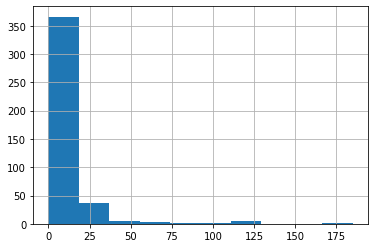

In [293]:
matches['punctuations'].hist()

In [294]:
mismatches['punctuations'] = mismatches['reviews'].apply(lambda x : count(x,set(string.punctuation)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


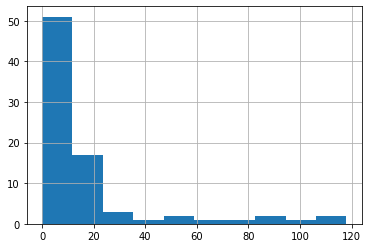

In [295]:
mismatches['punctuations'].hist()

From the above histogram plots, we can observe that the reviews which were correctly classified (matches) actually had more punctuation marks, than the reviews having incorrect predicted labels. Therefore punctuation marks cannot be a reason for the low performance of the tuned-model on this out of sample dataset

#### d. (2 points) Manually write down 3 examples that conform to the pattern you observed, and run inference on them using the model. What did you find?


In [ ]:
################## YOUR CODE HERE ##################
# Inference on your own examples
####################################################

**Answer:**

[YOUR ANSWER HERE]

In [332]:
example1 = "I loved the look! The knob to turn it on and off felt cheap hard to turn on and not pass FM always went to am and gently back to fm. Very cheap plastic but still super cute. I am sad it only lasted about 45 days and died if your handy you could probably take apart and solder some wires I did not attempt that just returned they kept about 5 bucks for my return. I’d love another just for the looks but don’t need if it’s gonna die quickly."
label1 = 0
example2 = "This radio is cute and portable which is why we ordered it. We like to listen to baseball games/music out by the pool and our wireless doesn't extend that far. The first weekend this worked fine with no problems. On the second weekend, the on and off button started going wonky and only a loud noise came out, instead of music. The next weekend it seemed fine again, as long as we are gentle with the on and off button."
label2 = 0
example3 = "Such an adorable retro radio. I took it on a trip and have moved it up and down stairs with me. However, it's nothing compared to the model we previously owened, thaat model was just phenomenal, this one is lovely but I am not sure I would recommend it other people."
labels3 = 0

In [333]:
examples = [example1, example2, example3]
labels = [label1, label2, label3]
sample_ooo = pd.DataFrame(list(zip(examples, labels)), columns = ['reviews','labels'])

In [334]:
sample_ooo

,reviews,labels
0,I loved the look! The knob to turn it on and o...,0
1,This radio is cute and portable which is why w...,0
2,Such an adorable retro radio. I took it on a t...,1


In [435]:
result_out_sample_test_ooo = make_predictions_out_sample(sample_ooo)

***** Running Prediction *****
  Num examples = 3
  Batch size = 4


In [436]:
result_out_sample_test_ooo

,Probabilities,Labels
0,0.993584,1
1,0.993971,1
2,0.994403,1


#### e. (2 points) Suggest what steps we might take to address this error bucket.


I belive all such reviews which meet the followig conditions must be addded to the dataset to finetune the performance of the model:

1) More reviews with rating of 3 and above which suggest a comparison of the product in question with another product, discussing the shortcoming of the product and the overal recommendation provided by the user should be added to the dataset.

2) Reviews with a rating of 2, which mostly talk about the merits of the product in question , but give an overall lower rating leading to a lable of 0 should instead be lablled as one that is a relabelling needs to be performed on such specific reviews. Though this data annotation step could be expensive, yet it would help the model pick additional signal from the features and would thus improve the performance of the model

3) Lastly, another avenue which can be explored is to use a different model which aims at improving the semantic structure understanding of the modela and uses attention mechanishm along with transfer learning to improve the classification performance.

References : https://link.springer.com/article/10.1007/s11227-021-04208-2

**Answer:**

[YOUR ANSWER HERE]

### 3.3 Calibration [4 points]
You will examine whether the fine-tuned model is calibrated. You might want to look into [sklearn.calibration.calibration_curve](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.calibration_curve.html).


#### a. (1 point) Compute the average calibration error of the fine-tuned model on IMDB.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [430]:
# def compute_average_claibration_error(data_sample, data_result, DATASET_NAME):
#   #data_sample = data_sample.reset_index().iloc[:,1:]
#   #data_result = data_result.reset_index().iloc[:,1:]
  


In [441]:
################## YOUR CODE HERE ##################

####################################################



DATASET_NAME = "IMDB"

result_sample_test.head().columns = ['Probabilities','Labels']
sample_testData.columns = ['reviews','ground_truth']
calibration_measure = pd.concat([result_sample_test, sample_testData], axis = 1)
calibration_measure = calibration_measure[['Probabilities','Labels','ground_truth']]

calibration_measure['probabililty_range'] = pd.cut(calibration_measure.Probabilities, [0.0,0.25,0.5,0.75,1.0], include_lowest=True)

bins_count = calibration_measure.groupby(['probabililty_range'])['Probabilities'].count().reset_index()
bins_count.columns = ['bins','count']

calibration_measure['correctly_labeled'] = [1  if item1 == item2 else 0 for item1,item2 in zip(calibration_measure['Labels'], calibration_measure['ground_truth'])]

bins_correct = calibration_measure.groupby(['probabililty_range'])['correctly_labeled'].sum().reset_index()
bins_correct.columns = ['bins','correct']

bins_performance = pd.merge(bins_correct, bins_count, how = 'inner', left_on = ['bins'], right_on  = ['bins'])
bins_performance['accuracy_bin'] = bins_performance['correct']/bins_performance['count']
bins_performance['accuracy_bin'] = bins_performance['accuracy_bin'].fillna(0)
bins_mean_probabilities = calibration_measure.groupby(['probabililty_range'])['Probabilities'].mean().reset_index()
bins_mean_probabilities.columns =  ['bins','average_probability']
bins_performance = pd.merge(bins_performance, bins_mean_probabilities, how = 'inner', left_on = ['bins'], right_on  = ['bins'])
bins_performance['absolute_delta'] = np.abs(bins_performance['accuracy_bin'] - bins_performance['average_probability'])
bins_performance['CE'] = bins_performance['count'] * bins_performance['absolute_delta']


bins_performance['average_probability'] = bins_performance['average_probability'].fillna(0)
bins_performance['absolute_delta'] = bins_performance['absolute_delta'].fillna(0)
bins_performance['CE'] = bins_performance['CE'].fillna(0)

print( "Average Calibration Error on " + DATASET_NAME + " : ", sum(bins_performance['CE'])/sum(bins_performance['count']))
#compute_average_claibration_error(sample_testData, result_sample_test, DATASET_NAME)


Average Calibration Error on IMDB :  0.49973499863967297


#### b. (1 point) Compute the average calibration error of the fine-tuned model on the out-of-distribution dataset


In [442]:


DATASET_NAME = "out_of-distribution"
################## YOUR CODE HERE ##################

####################################################


result_out_sample_test.columns = ['Probabilities','Labels']
out_sample_500.columns = ['reviews','ground_truth']
calibration_measure = pd.concat([result_out_sample_test, out_sample_500], axis = 1)
calibration_measure = calibration_measure[['Probabilities','Labels','ground_truth']]

calibration_measure['probabililty_range'] = pd.cut(calibration_measure.Probabilities, [0.0,0.25,0.5,0.75,1.0], include_lowest=True)

bins_count = calibration_measure.groupby(['probabililty_range'])['Probabilities'].count().reset_index()
bins_count.columns = ['bins','count']

calibration_measure['correctly_labeled'] = [1  if item1 == item2 else 0 for item1,item2 in zip(calibration_measure['Labels'], calibration_measure['ground_truth'])]

bins_correct = calibration_measure.groupby(['probabililty_range'])['correctly_labeled'].sum().reset_index()
bins_correct.columns = ['bins','correct']

bins_performance = pd.merge(bins_correct, bins_count, how = 'inner', left_on = ['bins'], right_on  = ['bins'])
bins_performance['accuracy_bin'] = bins_performance['correct']/bins_performance['count']
bins_performance['accuracy_bin'] = bins_performance['accuracy_bin'].fillna(0)
bins_mean_probabilities = calibration_measure.groupby(['probabililty_range'])['Probabilities'].mean().reset_index()
bins_mean_probabilities.columns =  ['bins','average_probability']
bins_performance = pd.merge(bins_performance, bins_mean_probabilities, how = 'inner', left_on = ['bins'], right_on  = ['bins'])
bins_performance['absolute_delta'] = np.abs(bins_performance['accuracy_bin'] - bins_performance['average_probability'])
bins_performance['CE'] = bins_performance['count'] * bins_performance['absolute_delta']


bins_performance['average_probability'] = bins_performance['average_probability'].fillna(0)
bins_performance['absolute_delta'] = bins_performance['absolute_delta'].fillna(0)
bins_performance['CE'] = bins_performance['CE'].fillna(0)

print( "Average Calibration Error on " + DATASET_NAME + " : ", sum(bins_performance['CE'])/sum(bins_performance['count']))
#compute_average_claibration_error(sample_testData, result_sample_test, DATASET_NAME)


Average Calibration Error on out_of-distribution :  0.23898653195053338


#### c. (2 points) Plot the calibration curves for the fine-tuned model on both datasets.


In [ ]:
################## YOUR CODE HERE ##################

####################################################

In [445]:
# while True:pass

**Answer:**

[YOUR ANSWER HERE]

## Problem 4. Multilabel Tasks [20 points]

Now we’ll be using our understanding of pretrained models and fine-tuned models to try to get good performance on a difficult dataset.

Choose one of the following multilabel tasks:
- Circa dataset: https://huggingface.co/datasets/circa 
- PUBHEALTH dataset: https://huggingface.co/datasets/health_fact
- GoEmotions dataset: https://huggingface.co/datasets/go_emotions

**Tip:** read the paper associated with each dataset.


### 4.1 Analyze a multi-label classification dataset [7 points]

#### a. (2 points) Describe the train/test split distributions, the dataset’s columns, and their statistics.


**Answer:**

[YOUR ANSWER HERE]

#### b. (1 point) Plot its label distribution as a bar graph, with the labels on the x-axis and number of examples for each labels on the y-axis.


In [ ]:
################## YOUR CODE HERE ##################
# See https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.bar.html
####################################################

**Answer:**

[YOUR ANSWER HERE]

#### c. (2 points) What metric(s) would be appropriate for this dataset? Why?


**Answer:**

[YOUR ANSWER HERE]

#### d. (2 points) Explain why you might think that this dataset is hard.


**Answer:**

[YOUR ANSWER HERE]

### 4.2 Fine-tuning a model for your multi-label classification task [13 points]

#### a. (1 point) Select a pre-trained model and instantiate it with the appropriate number of classes for your task. You are free to choose any framework you'd like for this part (HuggingFace's models, PyTorch, TensorFlow, etc.) 

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### b. (3 points) Pre-process the dataset for training and evaluation 

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### c. (3 points) Fine tune the model on the pre-processed dataset

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### d. (3 points) Evaluate your model using the metrics you identified in 4.1 (c). 

In [ ]:
################## YOUR CODE HERE ##################

####################################################

#### e. (3 points) On what class of labels does your fine-tuned model perform particularly well? On what class of labels does your model not do well? Where might you find or how might you construct new examples of this class to supplement your model's training? 

For those who chose to analyze the GoEmotions dataset, a list of the emotions used in the dataset can be found [here](https://github.com/google-research/google-research/blob/master/goemotions/data/emotions.txt)

**Answer:**

[YOUR ANSWER HERE]